In [1]:
!pip install meditorch
!pip install torchsummary

     |████████████████████████████████| 77 kB 3.5 MB/s  eta 0:00:01


# **EDD**

**1.Downloading data and extracting files to ./EDD2020**  
ACCEPT COMPETITION RULES TO ACCESS DATA at https://edd2020.grand-challenge.org/


In [2]:

#===================================================
import zipfile
with zipfile.ZipFile('EDD2020.zip', 'r') as zip_ref:
    zip_ref.extractall('EDD2020')
    
!ls ./EDD2020/EDD2020_release-I_2020-01-15

Data you are downloading is protected under: Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
see: https://creativecommons.org/licenses/by-nc/4.0/
downloading... wait!!!
done... good luck with the EDD2020 challenge!!!
EDD_readme.md	bbox		masks	       originalImages
EDD_readme.pdf	class_list.txt	masksPerClass


In [3]:
# import cv2
# import numpy as np
# from matplotlib import pyplot as plt
# %matplotlib inline
# #opencv reads images as h(y-axis),w(x-axis),channels
# img = cv2.imread('../input/abominal/yeti_large.jpg')[:,:,::-1]
# img = flip_img_vertical(img)
# plt.imshow(img)
# plt.show()
# np.asarray(img).shape

In [27]:
def resize_my_images(src,dst,is_masks,img_size):
    import cv2
    import os
    import numpy as np

    i = 0
    path = src
    for img_name in sorted(os.listdir(path)):
        img = None
#         print(img_name)
        try:
            if not is_masks:
                img = cv2.imread(os.path.join(path, img_name))[:,:,::-1]#Reading as RGB
            elif is_masks:
                img = cv2.imread(os.path.join(path, img_name),cv2.IMREAD_GRAYSCALE)
    
            h, w = img.shape[:2]
            a1 = w/h
            a2 = h/w

            if(a1 > a2):
                #print('a1 > a2')
                # if width greater than height
                r_img = cv2.resize(img, (round(img_size * a1), img_size), interpolation = cv2.INTER_AREA)
                margin = int(r_img.shape[1]/6)
                crop_img = r_img[0:img_size, margin:(margin+img_size)]

            elif(a1 < a2):
                #print('a1 < a2')
                # if height greater than width
                r_img = cv2.resize(img, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
                margin = int(r_img.shape[0]/6)
                crop_img = r_img[margin:(margin+img_size), 0:img_size]

            elif(a1 == a2):
                #print('a1== a2')
                # if height and width are equal
                r_img = cv2.resize(img, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
                crop_img = r_img[0:img_size, 0:img_size]

            if(crop_img.shape[0] != img_size or crop_img.shape[1] != img_size):
                #print('someting....')
                crop_img = r_img[0:img_size, 0:img_size]

            if(crop_img.shape[0] == img_size and crop_img.shape[1] == img_size):
                if not is_masks:
                    cv2.imwrite(dst + img_name, crop_img[:,:,::-1])#SAVING AS RGB FORMAT 
                    #display_image(crop_img,is_mask=False)
                elif is_masks:
                    #converting masks: tif--->jpg   
                    cv2.imwrite(dst + img_name.split('.')[0]+'.jpg', crop_img)
                    #display_image(crop_img,is_mask=True)
                #print("Saving "+ img_name.split('.')[0] + " with dims: " + str(crop_img.shape))
                i += 1
            #print('><'*20)
        except:
            print('Could not save image.')
    if is_masks:
        print('no of masks saved: ',i)
    else:
        print('no of images saved: ',i)


In [49]:
!rm -rf ./EDD2020/resized_masks/
!mkdir ./EDD2020/resized_masks/
resize_my_images('./EDD2020/EDD2020_release-I_2020-01-15/masks/','./EDD2020/resized_masks/',is_masks=True,img_size=224)

no of masks saved:  502


In [50]:
!rm -rf ./EDD2020/resized_images/
!mkdir ./EDD2020/resized_images/
resize_my_images('./EDD2020/EDD2020_release-I_2020-01-15/originalImages/','./EDD2020/resized_images/',is_masks=False,img_size=224)

no of images saved:  386


### Note: no of masks = 502, no of images=386.   
Some images have more than 1 conditions-- BE,suspicious,HGD,cancer,polyp

In [7]:
#TO DISPLAY ANY IMAGE(RGB/GREY)
import cv2
def display_image(img,is_mask=False):
    from matplotlib import pyplot as plt
    %matplotlib inline
    if is_mask:
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)
    plt.show()
# mask = cv2.imread('./EDD2020/resized_masks/EDD2020_ACB0000_cancer.jpg',cv2.IMREAD_GRAYSCALE)
# display_image(mask,True)

**2.Defining class for preparing the dataset and other utility functions**




In [8]:
def flip_img_horizontal(img):
    '''
    assuming RGB image is in (h,w,c) format
    '''
    return img[:,::-1,:]
def flip_img_vertical(img):
    '''
    assuming RGB image is in (h,w,c) format
    '''
    return img[::-1,:,:]
def flip_mask_horizontal(mask):
    '''
    assuming greyscale mask is in (h,w) format
    '''
    return mask[:,::-1]
def flip_mask_vertical(mask):
    '''
    assuming greyscale mask is in (h,w) format
    '''
    return mask[::-1,:]

In [9]:
# from albumentations import (
#     PadIfNeeded,
#     HorizontalFlip,
#     VerticalFlip,    
#     CenterCrop,    
#     Crop,
#     Compose,
#     Transpose,
#     RandomRotate90,
#     ElasticTransform,
#     GridDistortion, 
#     OpticalDistortion,
#     RandomSizedCrop,
#     OneOf,
#     CLAHE,
#     RandomBrightnessContrast,    
#     RandomGamma    
# )
# %matplotlib inline
# import numpy as np
# import cv2
# from matplotlib import pyplot as plt

# def visualize(image, mask, original_image=None, original_mask=None):
#     fontsize = 18
    
#     if original_image is None and original_mask is None:
#         f, ax = plt.subplots(2, 1, figsize=(8, 8))

#         ax[0].imshow(image)
#         ax[1].imshow(mask)
#     else:
#         f, ax = plt.subplots(2, 2, figsize=(8, 8))

#         ax[0, 0].imshow(original_image)
#         ax[0, 0].set_title('Original image', fontsize=fontsize)
        
#         ax[1, 0].imshow(original_mask)
#         ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
#         ax[0, 1].imshow(image)
#         ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
#         ax[1, 1].imshow(mask)
#         ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [31]:
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

import torch
import os
import numpy as np
import glob
from PIL import Image
from skimage.transform import resize
from tqdm.notebook import tqdm
def load_image(path,is_mask):
    if not is_mask:
        return np.asarray(Image.open(path).convert("RGB"))
    else:
        return np.asarray(Image.open(path).convert('L'))

def load_set(folder,is_mask,shuffle=False):
    data = []
    img_list = sorted(glob.glob(os.path.join(folder, '*.jpg')))
    if shuffle:
        np.random.shuffle(img_list)
    for img_fn in img_list:
        img = load_image(img_fn,is_mask)
        data.append(img)
    return data, img_list

class EDD(Dataset):
    '''
    Class for preparing the EDD2020 dataset
    '''
    def __init__(self, root, imgsize, img_transform=None):
        self.root = root
        self.img_transform = img_transform
        self.original_images = None
        self.masks = None
        self.labels = None
        self._extract_images_and_segments(root,imgsize)

    def __getitem__(self,index):
        img = self.original_images[index]
        mask = self.masks[index]
    
        if self.img_transform:
            img = self.img_transform(img)
            
        else:
            transform_to_tensor = transforms.Compose([
                transforms.ToTensor(),
                #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],)
                #Normalizing makes images appear weird but necessary for resnet
            ])
            img = transform_to_tensor(img)
        
        return img, mask

    def __len__(self):
        return len(self.original_images)
    
    def _extract_images_and_segments(self,global_path,imgsize):
        '''
        Function to process images and their respective masks.
        It sets  self.original_images and self.masks to processed images at the end.
        '''
        images_path = os.path.join(global_path, 'resized_images')
        all_images, img_filenames = load_set(folder=images_path,is_mask=False)
        img_filenames_with_ext = [os.path.split(fn)[-1] for fn in img_filenames]
        img_filenames_wo_ext = [fn[:fn.rfind('.')] for fn in img_filenames_with_ext]

        classes = ['BE','suspicious','HGD','cancer','polyp']

        masks_path = os.path.join(global_path, 'resized_masks')
        all_masks, mask_filenames = load_set(folder=masks_path,is_mask=True)
        mask_filenames_with_ext = [os.path.split(fn)[-1] for fn in mask_filenames]
        mask_filenames_wo_ext = [fn[:fn.rfind('.')] for fn in mask_filenames_with_ext]
        temp_dict={}#contains 502 mask filenames as keys and respective masks as values
        for i in range(len(all_masks)):
            temp_dict[mask_filenames_wo_ext[i]]=all_masks[i]

        all_masks=[]
        all_labels=[]
        for img in img_filenames_wo_ext:
            masks_for_img = []
            temp_labels = []
            for c in classes:
                try:
                    mask_file_name = img+'_'+c
                    temp_dict[mask_file_name] = np.where(temp_dict[mask_file_name] > 0, 1, 0)
                    temp_dict[mask_file_name] = temp_dict[mask_file_name].astype(np.float32)
                    masks_for_img.append(temp_dict[mask_file_name].reshape(temp_dict[mask_file_name].shape+ (1,)))
                    temp_labels.append(1)
                except KeyError:
                    dummy = np.zeros((imgsize, imgsize)).astype(np.float32)
                    masks_for_img.append(dummy.reshape(dummy.shape + (1,)))
                    temp_labels.append(0)
            temp = None
            temp = np.concatenate(masks_for_img,2)#temp.shape (imgsize, imgsize, 5)
            temp = temp.reshape((1,)+temp.shape)#temp.shape (1, imgsize, imgsize, 5)
            all_masks.append(temp)
            all_labels.append(temp_labels)
            
        all_masks = np.vstack(all_masks)#all_masks.shape (386, imgsize, imgsize, 5)
        all_masks = np.moveaxis(all_masks,source=3,destination=1)#all_masks.shape (386, 5, imgsize, imgsize)
        
        all_images = np.asarray(all_images)
        all_images = all_images.astype(np.uint8)
        augmented_images = []
        augmented_masks = []
        
        print(">>>>>>>>>>>>>>>>Augmenting to increase data size<<<<<<<<<<<<<<<<<<<<<<<<<")
        for image,masks in tqdm(zip(all_images,all_masks)):
            image = np.asarray(image)
            #display_image(image)
            
            #print(image.shape,masks.shape)
            hflip_img = flip_img_horizontal(image)
            #display_image(hflip_img)
            vflip_img = flip_img_vertical(image)
            #display_image(vflip_img)
            
            temp_hor_masks = []#to store horizontally flipped masks for an image,which are later np.concatenated
            temp_ver_masks = []#to store vertically flipped masks for an image,which are later np.concatenated
            for mask in masks:
                temp_h = flip_mask_horizontal(mask).reshape((1,)+mask.shape)#reshaping (224,224)-->(1,224,224)
                temp_hor_masks.append(temp_h)
                temp_v = flip_mask_vertical(mask).reshape((1,)+mask.shape)#reshaping (224,224)-->(1,224,224)
                temp_ver_masks.append(temp_v)
                '''
                aug = HorizontalFlip(p=1)
                augmented = aug(image=image, mask=mask)
                image_padded = augmented['image']
                mask_padded = augmented['mask']
                visualize(image_padded, mask_padded, original_image=image, original_mask=mask)
                '''
            hflip_masks = np.concatenate(temp_hor_masks,0)#concatenating all 5 masks into 1 (224,224,5)
            vflip_masks = np.concatenate(temp_ver_masks,0)#concatenating all 5 masks into 1 (224,224,5)
            #print("flipped:",hflip_img.shape,hflip_masks.shape,vflip_img.shape,vflip_masks.shape)
            augmented_images.append(hflip_img)
            augmented_images.append(vflip_img)
            augmented_masks.append(hflip_masks.reshape((1,)+hflip_masks.shape))
            augmented_masks.append(vflip_masks.reshape((1,)+vflip_masks.shape))
            
        #images
        augmented_images = np.asarray(augmented_images)
        augmented_images = augmented_images.astype(np.uint8)
        print('orignial_images.shape',all_images.shape,'augmented_images.shape',augmented_images.shape)
        all_images = np.concatenate((all_images,augmented_images),axis=0)
        print('After augmentation, all_images.shape',all_images.shape)
        print("."*100)
        #masks
        augmented_masks = np.vstack(augmented_masks)
        print('orignial_masks.shape',all_masks.shape,'augmented_masks.shape',augmented_masks.shape)
        all_masks = np.concatenate((all_masks,augmented_masks),axis=0)
        print('After augmentation, all_masks.shape',all_masks.shape)
        print("*"*150)
        ################################results display
        print('len(all_images):',len(all_images),'len(all_masks):',len(all_masks))
        print('>>>>>>>>>>>Images<<<<<<<<<<<')
        print('type(all_images):',type(all_images),' all_images.shape:',all_images.shape)
        print('type(all_images[1]):',type(all_images[1]),' all_images[1].shape:',all_images[1].shape)
        print('.'*100)
        print('>>>>>>>>>>>Masks<<<<<<<<<<<<')
        print('type(all_masks):',type(all_masks),'all_masks.shape:',all_masks.shape)
        print('type(all_masks[1]):',type(all_masks[1]),'all_masks[1].shape:',all_masks[1].shape)
        print('.'*100)
        
        self.masks = all_masks
        self.original_images = all_images
        self.labels = all_labels

In [ ]:
# #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>SCRATCH PAD<<<<<<<<<<<<<<<<<<<<<<<<<
# from torch.utils.data import DataLoader
# from torch.utils.data.sampler import SubsetRandomSampler
# np.random.seed(42)
# dataset = EDD('./EDD2020/')
# # for i in range(25):
# #     print(i+1,':->',type(dataset[i][0]),dataset[i][0].shape,type(dataset[i][1]),dataset[i][1].shape)
# dataset_size = 100#len(dataset)
# indices = list(range(dataset_size))
# split = int(np.floor(0.25 * dataset_size))
# #np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]
# train_sampler = torch.utils.data.sampler.SequentialSampler(train_indices)#change to SubsetRandomSampler
# loader = DataLoader(dataset, batch_size=4, sampler=train_sampler)

**3.instantiating class and splitting it into train,val set**


In [35]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
np.random.seed(42)
def get_edd_loader(path,imgsize,validation_split=.25,shuffle_dataset=True):
    dataset = EDD(path,imgsize) #instantiating the data set.
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    loader={
        'train':DataLoader(dataset, batch_size=8, sampler=train_sampler),
        'val':DataLoader(dataset, batch_size = 4,sampler=valid_sampler)
    }
    return loader

**4.Defining Trainer and losses**

In [36]:
from collections import defaultdict
import copy
import time
import torch
from meditorch.utils.plot import metrics_line, normalise_mask
import numpy as np



def cal_dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice_coeff = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    dice_loss = 1 - dice_coeff
    return dice_loss.mean()

def intersection_over_union(target, pred):
    target = target.flatten()
    pred = pred.flatten()
    intersect = np.dot(target, pred)
    union = (target + pred).sum() - intersect
    return intersect/union

def calc_loss(pred, target, metrics, bce_weight):
    bce = torch.nn.functional.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice_loss = cal_dice_loss(pred, target)
    pred_binary = normalise_mask(pred.detach().cpu().numpy())
    iou = intersection_over_union(target.detach().cpu().numpy(), pred_binary)

    loss = bce * bce_weight + dice_loss * (1 - bce_weight)
     
    metrics['bce_loss'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice_loss'] += dice_loss.data.cpu().numpy() * target.size(0)
    metrics['iou'] += iou * target.size(0)
    metrics['total_loss'] += loss.data.cpu().numpy() * target.size(0)
    return loss

def compute_metrics(metrics, epoch_samples):
    computed_metrics = {}
    for k in metrics.keys():
        computed_metrics[k] = metrics[k] / epoch_samples
    return computed_metrics

def print_metrics(computed_metrics, phase):
    outputs = []
    for k in computed_metrics.keys():
        outputs.append("{}:{:4f}".format(k, computed_metrics[k]))
    print("\t{}  -> {}".format(phase.ljust(5), " | ".join(outputs)))

class Trainer(object):

    def __init__(self, model, optimizer=None, scheduler=None):

        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Customized trainer\t",'Device====>',self.device)
        self.model = model.to(self.device)

        self.optimizer = optimizer
        if self.optimizer == None:
            print("optimizer undefined, hence using default Adam optimizer..")
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        self.scheduler = scheduler
        if self.scheduler == None:
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)


    def train_model(self, dataloaders,bce_weight, num_epochs=20):
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_loss = 1e10
        epochs_metrics = {
            'train': [],
            'val': []
        }

        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch+1, num_epochs))

            since = time.time()

            # Each epoch has a training phase, followed by a validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    for param_group in self.optimizer.param_groups:
                        print("\tlearning rate: {:.2e}".format(param_group['lr']))
                    self.model.train()  # Set model to training mode
                else:
                    self.model.eval()   # Set model to evaluate mode
                metrics = defaultdict(float)
                epoch_samples = 0

                for inputs, targets in dataloaders[phase]:#phase is either train or val
                    masks = targets
                    #print('>>>>>>>>>>>',inputs.shape,masks.shape,'<<<<<<<<<<<<<<<<<<')
                

                    inputs = inputs.to(self.device)
                    masks = masks.to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    # forwar track history for training phase only
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        loss = calc_loss(outputs, masks, metrics,bce_weight)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)

                computed_metrics = compute_metrics(metrics, epoch_samples)
                print_metrics(computed_metrics, phase)
                epochs_metrics[phase].append(computed_metrics)
                epoch_loss = metrics['total_loss'] / epoch_samples

                if phase == 'train':
                    self.scheduler.step()

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    print("\tCurrent epoch loss {:4f} is less than previous epoch loss {:4f}".format(epoch_loss, best_loss))
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(self.model.state_dict())

            time_elapsed = time.time() - since
            print('\t{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('-' * 10)

        print('Best val loss: {:4f}'.format(best_loss))
        print('Saving best model')
        self.model.load_state_dict(best_model_wts)# load best model weights

        metrics_line(epochs_metrics)

    def predict(self, X, threshold=0.5):
        self.model.eval()
        inputs = X.to(self.device)
        pred = self.model(inputs)
        pred = pred.data.cpu().numpy()
        pred = normalise_mask(pred, threshold)
        return pred




**5.Defining the model: Unet+Resnet**  


In [19]:
# import torch
# import torch.nn as nn
# from torchvision import models

# def convrelu(in_channels, out_channels, kernel, padding):
#     return nn.Sequential(
#         nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
#         nn.ReLU(inplace=True),
#     )


# class UNetResNet(nn.Module):

#     def __init__(self, in_channel, n_classes):
#         super().__init__()
#         self.base_model = models.resnet50()
#         self.base_model.load_state_dict(torch.load("../input/resnet50/resnet50.pth"))

#         self.base_layers = list(self.base_model.children())

#         self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
#         self.layer0_1x1 = convrelu(64, 64, 1, 0)
#         self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
#         self.layer1_1x1 = convrelu(64, 64, 1, 0)
#         self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
#         self.layer2_1x1 = convrelu(128, 128, 1, 0)
#         self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
#         self.layer3_1x1 = convrelu(256, 256, 1, 0)
#         self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
#         self.layer4_1x1 = convrelu(512, 512, 1, 0)

#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#         self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
#         self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
#         self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
#         self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

#         self.conv_original_size0 = convrelu(in_channel, 64, 3, 1)
#         self.conv_original_size1 = convrelu(64, 64, 3, 1)
#         self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

#         self.conv_last = nn.Conv2d(64, n_classes, 1)

#     def forward(self, input):
#         x_original = self.conv_original_size0(input)
#         x_original = self.conv_original_size1(x_original)

#         layer0 = self.layer0(input)
#         layer1 = self.layer1(layer0)
#         layer2 = self.layer2(layer1)
#         layer3 = self.layer3(layer2)
#         layer4 = self.layer4(layer3)

#         layer4 = self.layer4_1x1(layer4)
#         x = self.upsample(layer4)
#         layer3 = self.layer3_1x1(layer3)
#         x = torch.cat([x, layer3], dim=1)
#         x = self.conv_up3(x)

#         x = self.upsample(x)
#         layer2 = self.layer2_1x1(layer2)
#         x = torch.cat([x, layer2], dim=1)
#         x = self.conv_up2(x)

#         x = self.upsample(x)
#         layer1 = self.layer1_1x1(layer1)
#         x = torch.cat([x, layer1], dim=1)
#         x = self.conv_up1(x)

#         x = self.upsample(x)
#         layer0 = self.layer0_1x1(layer0)
#         x = torch.cat([x, layer0], dim=1)
#         x = self.conv_up0(x)

#         x = self.upsample(x)
#         x = torch.cat([x, x_original], dim=1)
#         x = self.conv_original_size2(x)

#         out = self.conv_last(x)

#         return out

In [72]:
from meditorch.nn.models import UNetResNet
from torchsummary import summary
import torch.optim as optim
#from meditorch.nn import Trainer

from torch.optim import lr_scheduler
from meditorch.utils.plot import plot_image_truemask_predictedmask
model = UNetResNet(in_channel=3,n_classes=5)
optimizer_func = optim.Adam(model.parameters(), lr=0.003)
#optimizer_func = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = 1e-2, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer_func, step_size=5, gamma=1e-1)
MODELPATH = './resnet18_224'
model.load_state_dict(torch.load(MODELPATH))
model.eval()
trainer = Trainer(model, optimizer=optimizer_func, scheduler=scheduler)

Customized trainer	 Device====> cuda


**6.Training**

Training was done in 2 stages:-  
1. Initially the Neural network was trained on 128-sized images and weights were saved.  
2. Weights from step1 were loaded and trained on 224-sized images

In [53]:
loader = get_edd_loader('./EDD2020/',imgsize=224,validation_split=.25,shuffle_dataset=True)

>>>>>>>>>>>>>>>>Augmenting to increase data size<<<<<<<<<<<<<<<<<<<<<<<<<



orignial_images.shape (386, 224, 224, 3) augmented_images.shape (772, 224, 224, 3)
After augmentation, all_images.shape (1158, 224, 224, 3)
....................................................................................................
orignial_masks.shape (386, 5, 224, 224) augmented_masks.shape (772, 5, 224, 224)
After augmentation, all_masks.shape (1158, 5, 224, 224)
******************************************************************************************************************************************************
len(all_images): 1158 len(all_masks): 1158
>>>>>>>>>>>Images<<<<<<<<<<<
type(all_images): <class 'numpy.ndarray'>  all_images.shape: (1158, 224, 224, 3)
type(all_images[1]): <class 'numpy.ndarray'>  all_images[1].shape: (224, 224, 3)
....................................................................................................
>>>>>>>>>>>Masks<<<<<<<<<<<<
type(all_masks): <class 'numpy.ndarray'> all_masks.shape: (1158, 5, 224, 224)
type(all_masks[1]): <class '

#### total_loss = bce_loss . bce_weight + dice_loss . (1 - bce_weight)    
bce_loss := classification error, i.e. error in choosing the color of mask(scroll below).  
dice_loss ~ area left out while overlapping target mask and predicted mask.  

Epoch 1/25:
	learning rate: 3.00e-03
	train  -> bce_loss:0.544096 | dice_loss:0.373686 | iou:0.141388 | total_loss:0.441850
	val    -> bce_loss:0.569403 | dice_loss:0.385794 | iou:0.126623 | total_loss:0.459238
	Current epoch loss 0.459238 is less than previous epoch loss 10000000000.000000
	0m 18s
----------
Epoch 2/25:
	learning rate: 3.00e-03
	train  -> bce_loss:0.478597 | dice_loss:0.406291 | iou:0.176722 | total_loss:0.435213
	val    -> bce_loss:0.542476 | dice_loss:0.396427 | iou:0.131725 | total_loss:0.454846
	Current epoch loss 0.454846 is less than previous epoch loss 0.459238
	0m 18s
----------
Epoch 3/25:
	learning rate: 3.00e-03
	train  -> bce_loss:0.480575 | dice_loss:0.397167 | iou:0.186248 | total_loss:0.430530
	val    -> bce_loss:0.533618 | dice_loss:0.397412 | iou:0.208061 | total_loss:0.451894
	Current epoch loss 0.451894 is less than previous epoch loss 0.454846
	0m 18s
----------
Epoch 4/25:
	learning rate: 3.00e-03
	train  -> bce_loss:0.478132 | dice_loss:0.390386 

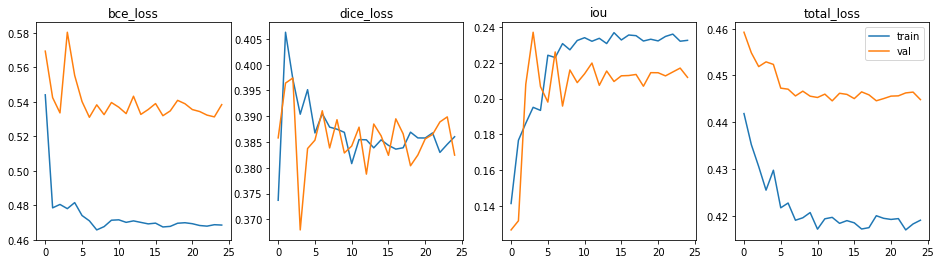

In [73]:
trainer.train_model(loader,bce_weight=0.4, num_epochs=25)

In [64]:
#Saving the model
MODELPATH = './resnet18_224'
torch.save(model.state_dict(), MODELPATH)

### 7. Predictions

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce


def metrics_line(data):
    phases = list(data.keys())
    metrics = list(data[phases[0]][0].keys())

    i = 0
    fig, axs = plt.subplots(1, len(metrics))
    fig.set_figheight(4)
    fig.set_figwidth(4*len(metrics))
    for metric in metrics:
        for phase in phases:
            axs[i].plot([i[metric] for i in data[phase]], label=phase)
        axs[i].set_title(metric)
        i+=1

    plt.legend()
    plt.show()


def normalise_mask(mask, threshold=0.5):
    mask[mask > threshold] = 1
    mask[mask <= threshold] = 0
    return mask

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    return inp

def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))
    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

def plot_image_truemask_predictedmask2(images, labels, preds):

    input_images_rgb = [reverse_transform(x) for x in images]
    target_masks_rgb = [masks_to_coloredmasks(x) for x in labels]
    pred_masks_rgb   = [masks_to_coloredmasks(x) for x in preds]

    img_arrays = [input_images_rgb, target_masks_rgb, pred_masks_rgb]
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))
    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

def apply_mask_color(mask, mask_color):
    colored_mask = np.concatenate(([mask[ ... , np.newaxis] * color for color in mask_color]), axis=2)
    return colored_mask.astype(np.uint8)

def masks_to_coloredmasks(mask, normalise=True, colors=None):
    '''
    To assign colors to the different classes, for identification purpose only!
    '''
    segments_colors = np.asarray([(0, 255, 255), (0,0,255), (0, 255, 0), (255, 0, 0),(255, 255, 0)])
    if colors is not None:
        segments_colors = colors

    if normalise:
        normalise_mask(mask)

    mask_colored = np.concatenate( [ [apply_mask_color(mask[i], segments_colors[i])] for i in range(len(mask)) ] )
    mask_colored = np.max(mask_colored, axis=0)

    mask_colored = np.where(mask_colored.any(-1,keepdims=True),mask_colored,255)

    return mask_colored



----------------------------------------------  
BE         = cyan  
suspicious = blue  
HGD        = green  
cancer     = red  
polyp      = yellow

torch.Size([4, 3, 224, 224]) torch.Size([4, 5, 224, 224]) (4, 5, 224, 224)


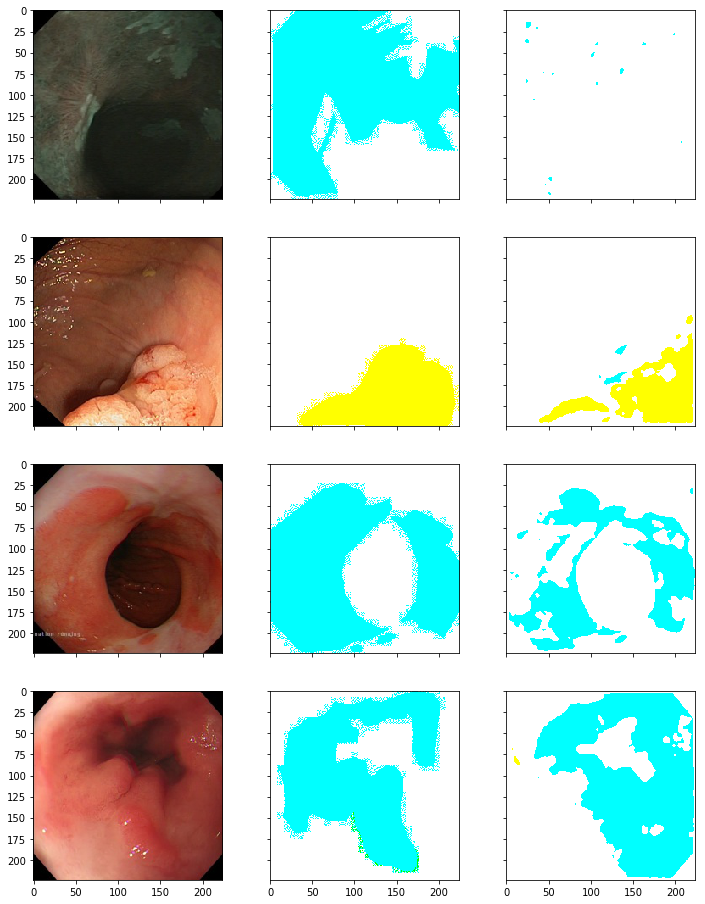

In [77]:
images, target = next(iter(loader['val']))#fetch the next batch of images and respective masks
preds = trainer.predict(images)
print(images.shape,target.shape,preds.shape)
plot_image_truemask_predictedmask2(images, target, preds)

In [ ]:
#To view dubious masks
for i in range(5):
    display_image(np.asarray(target[0][i]),True)

## Other approaches modelling only the claasification: 
--under construction.  
Modelling the distribution of each one of the RGB pixels of the image where the masks show positive


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

import torch
import os
import numpy as np
import glob
from PIL import Image
from skimage.transform import resize
from tqdm.notebook import tqdm
def load_image(path,is_mask):
    if not is_mask:
        return np.asarray(Image.open(path).convert("RGB"))
    else:
        return np.asarray(Image.open(path).convert('L'))

def load_set(folder,is_mask,shuffle=False):
    data = []
    img_list = sorted(glob.glob(os.path.join(folder, '*.jpg')))
    if shuffle:
        np.random.shuffle(img_list)
    for img_fn in img_list:
        img = load_image(img_fn,is_mask)
        data.append(img)
    return data, img_list

class EDD2(Dataset):
    '''
    Class for preparing the EDD2020 dataset
    '''
    def __init__(self, root, img_transform=None):
        self.root = root
        self.img_transform = img_transform
        self.original_images = None
        self.masks = None
        self.labels = None
        self._extract_images_and_segments(root)

    def __getitem__(self,index):
        img = self.original_images[index]
        mask = self.masks[index]
    
        if self.img_transform:
            img = self.img_transform(img)
            
        else:
            transform_to_tensor = transforms.Compose([
                transforms.ToTensor(),
            ])
            img = transform_to_tensor(img)
        
        return img, mask

    def __len__(self):
        return len(self.original_images)
    
    def _extract_images_and_segments(self,global_path):
        '''
        Function to process images and their respective masks.
        It sets  self.original_images and self.masks to processed images at the end.
        '''
        images_path = os.path.join(global_path, 'resized_images')
        all_images, img_filenames = load_set(folder=images_path,is_mask=False)
        img_filenames_with_ext = [os.path.split(fn)[-1] for fn in img_filenames]
        img_filenames_wo_ext = [fn[:fn.rfind('.')] for fn in img_filenames_with_ext]

        classes = ['BE','suspicious','HGD','cancer','polyp']

        masks_path = os.path.join(global_path, 'resized_masks')
        all_masks, mask_filenames = load_set(folder=masks_path,is_mask=True)
        mask_filenames_with_ext = [os.path.split(fn)[-1] for fn in mask_filenames]
        mask_filenames_wo_ext = [fn[:fn.rfind('.')] for fn in mask_filenames_with_ext]
        temp_dict={}#contains 502 mask filenames as keys and respective masks as values
        for i in range(len(all_masks)):
            temp_dict[mask_filenames_wo_ext[i]]=all_masks[i]

        all_masks=[]
        all_labels=[]
        for img in img_filenames_wo_ext:
            masks_for_img = []
            temp_labels = []
            for c in classes:
                try:
                    mask_file_name = img+'_'+c
                    temp_dict[mask_file_name] = np.where(temp_dict[mask_file_name] > 0, 1, 0)
                    temp_dict[mask_file_name] = temp_dict[mask_file_name].astype(np.float32)
                    masks_for_img.append(temp_dict[mask_file_name].reshape(temp_dict[mask_file_name].shape+ (1,)))
                    temp_labels.append(1)
                except KeyError:
                    dummy = np.zeros((224, 224)).astype(np.float32)
                    masks_for_img.append(dummy.reshape(dummy.shape + (1,)))
                    temp_labels.append(0)
            temp = None
            temp = np.concatenate(masks_for_img,2)#temp.shape (224, 224, 5)
            temp = temp.reshape((1,)+temp.shape)#temp.shape (1, 224, 224, 5)
            all_masks.append(temp)
            all_labels.append(temp_labels)
            
        all_masks = np.vstack(all_masks)#all_masks.shape (386, 224, 224, 5)
        all_masks = np.moveaxis(all_masks,source=3,destination=1)#all_masks.shape (386, 5, 224, 224)
        
        all_images = np.asarray(all_images)
        all_images = all_images.astype(np.uint8)
        
        print('len(all_images):',len(all_images),'len(all_masks):',len(all_masks))
        print('>>>>>>>>>>>Images<<<<<<<<<<<')
        print('type(all_images):',type(all_images),' all_images.shape:',all_images.shape)
        print('type(all_images[1]):',type(all_images[1]),' all_images[1].shape:',all_images[1].shape)
        print('.'*100)
        print('>>>>>>>>>>>Masks<<<<<<<<<<<<')
        print('type(all_masks):',type(all_masks),'all_masks.shape:',all_masks.shape)
        print('type(all_masks[1]):',type(all_masks[1]),'all_masks[1].shape:',all_masks[1].shape)
        print('.'*100)
        
        self.masks = all_masks
        self.original_images = all_images
        self.labels = all_labels

In [ ]:
all_be = []
all_sus = []
all_hgd = []
all_cancer = []
all_polyp = []
all_image = []
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
np.random.seed(42)
dataset = EDD2('./EDD2020/')
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.25 * dataset_size))
#np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = torch.utils.data.sampler.SequentialSampler(train_indices)#change to SubsetRandomSampler
loader = DataLoader(dataset, batch_size=1, sampler=train_sampler)
for batch in loader:
    image = batch[0][0]#torch.Size([3, 224, 224])
    mask = batch[1][0]
    be = mask[0]
    sus = mask[1]
    hgd = mask[2]
    cancer = mask[3]
    polyp = mask[4]
    all_image.append(image)
    all_be.append(be)
    all_sus.append(sus)
    all_hgd.append(hgd)
    all_cancer.append(cancer)
    all_polyp.append(polyp)
len(all_be),len(all_sus),len(all_hgd),len(all_cancer),len(all_polyp),len(all_image)

In [ ]:
def get_rgb_pixels(x):
    index = []
    coords= []
    for i,mask in enumerate(x):
        if np.argwhere(np.asarray(mask)>0).shape[0]!=0:#0-->black,1-->white
            index.append(i)
            coords.append(np.argwhere(np.asarray(mask)>0))
    print('len(index)',len(index))
    r_pixels = []
    g_pixels = []
    b_pixels = []
    for ind,coord in zip(index,coords):
    #print(i,coords.shape)
        r=np.asarray(all_image[ind][0])
        g=np.asarray(all_image[ind][1])
        b=np.asarray(all_image[ind][2])
        for c in coord:
            r_pixels.append(r[c[0]][c[1]])
            g_pixels.append(g[c[0]][c[1]])
            b_pixels.append(b[c[0]][c[1]])
    return r_pixels,g_pixels,b_pixels

In [ ]:
results = []
for t in [all_be,all_sus,all_hgd,all_cancer,all_polyp]:
    results.append(get_rgb_pixels(t))

In [ ]:
avrged_pixels = []#len=5
for rlist,glist,blist in results:
    temp = []
    for r,g,b in zip(rlist,glist,blist):
        temp.append((r+g+b)/3.0)
    avrged_pixels.append(temp)
        

In [ ]:
def plotit(l,c):
    import seaborn as sns
    sns.set()
    sns.distplot(l,color=c)
    

In [ ]:
col=['c','b','g','r','y']
for cat,col in zip(avrged_pixels,col):
    plotit(cat,col)
#ALL 5 categories plot: the rgb pixels have been avrged 

In [ ]:
import seaborn as sns
sns.set()
#distribution of red pixels of all 5 categories
sns.distplot(r_be,color='c')
sns.distplot(r_sus,color='b')
sns.distplot(r_hgd,color='g')
sns.distplot(r_can,color='r')
sns.distplot(r_polyp,color='y')

In [ ]:
#distribution of green pixels of all 5 categories
sns.distplot(g_be,color='c')
sns.distplot(g_sus,color='b')
sns.distplot(g_hgd,color='g')
sns.distplot(g_can,color='r')
sns.distplot(g_polyp,color='y')

In [ ]:
#distribution of blue pixels of all 5 categories
sns.distplot(b_be,color='c')
sns.distplot(b_sus,color='b')
sns.distplot(b_hgd,color='g')
sns.distplot(b_can,color='r')
sns.distplot(b_polyp,color='y')

## Miscellaneous:-

In [ ]:
for batch_image,batch_mask in (loader['train']): #every iteration fetches data of size batchsize
    print('adfaf')
    print(batch_image.shape,batch_mask.shape)
    for image in batch_image:
        im = transforms.ToPILImage()(image).convert("RGB")
        display(im)
    

In [ ]:
type(dataset[0][0]),dataset[0][0].shape,type(dataset[0][1]),dataset[0][1].shape

In [ ]:
#TO GENERATE MASKS
t=dataset[5][1]
t=t.astype(np.float32)
for i in range(5):
    tx=t[i,:,:]
    tx=tx.reshape((1,)+tx.shape)
    tx=torch.from_numpy(tx)
    im=transforms.ToPILImage()(tx)
    display(im)

In [ ]:
t=dataset[0][0]
from torchvision import transforms
im = transforms.ToPILImage()(t).convert("RGB")
display(im)
print(im.size)

In [ ]:
#TO COMBINE ALL MULTIPLE MASKS INTO ONE
    
if __name__ == '__main__':
    import tifffile as tiff
    from tifffile import imsave
    import cv2
    import numpy as np
    import glob
    import os
    imgdir='./EDD2020/EDD2020_release-I_2020-01-15/originalImages/'
    maskdir='./EDD2020/EDD2020_release-I_2020-01-15/masks/'
    outputdir='./EDD2020/EDD2020_release-I_2020-01-15/outputdir/'
    
    os.makedirs(outputdir, exist_ok=True)
    
    categoryList = ['BE', 'suspicious', 'HGD' , 'cancer', 'polyp']
    
    ext = ['*.jpg']
    for filename in sorted(glob.glob(imgdir + '/'+ ext[0], recursive = True)):
        file=filename.split('/')[-1]
        fileNameOnly = file.split('.')[0]
        nClasses_annotated = len(glob.glob1(maskdir,fileNameOnly+"*.tif"))
        fileList = glob.glob1(maskdir,fileNameOnly+"*.tif")
       
        # read original and make stack of mask images
        image = cv2.imread(filename)
        height, width = image.shape[:2]
        mask = np.zeros([height, width, len(categoryList)], dtype=np.uint8)
        
        for i in range (0, nClasses_annotated):
            f = fileList[i].split('_')[-1]
            if f.split('.')[0] == 'BE':
                mask[:,:, 0] = tiff.imread(os.path.join(maskdir,fileList[i]))
            elif (f.split('.')[0]== 'suspicious'):
                mask[:,:, 1] = tiff.imread(os.path.join(maskdir,fileList[i]))
            elif (f.split('.')[0] == 'HGD'):
                mask[:,:, 2] = tiff.imread(os.path.join(maskdir,fileList[i]))
            elif (f.split('.')[0] == 'cancer'):
                mask[:,:, 3] = tiff.imread(os.path.join(maskdir,fileList[i]))
            elif (f.split('.')[0] == 'polyp'):
                mask[:,:, 4] = tiff.imread(os.path.join(maskdir,fileList[i]))
                
                
            im_mask = mask.transpose([2,0,1])    
            imsave(os.path.join(outputdir,fileNameOnly+'_mask.tif'), im_mask)      
            